## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.23.1'

## Loading the data

In [2]:
df = pd.read_csv('./Symptom2DiseaseID.csv', delimiter=';')
df.head()

,indeks,label,text
0,0,Psoriasis,"Saya telah mengalami ruam kulit di lengan, ka..."
1,1,Psoriasis,"Kulit saya mengelupas, terutama di lutut, sik..."
2,2,Psoriasis,"Saya telah mengalami nyeri sendi di jari, per..."
3,3,Psoriasis,"Ada debu seperti perak di kulit saya, terutam..."
4,4,Psoriasis,Kuku saya memiliki penyok atau lubang kecil d...


In [8]:
df.drop("indeks", axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1200 non-null   object
 1   text    1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


Creating encodings for disease.

In [10]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: ' Psoriasis',
  1: ' Pembuluh mekar',
  2: ' Penyakit tipus',
  3: ' Cacar air',
  4: ' Impetigo',
  5: ' demam berdarah',
  6: ' Infeksi jamur',
  7: ' Flu biasa',
  8: ' Radang paru-paru',
  9: ' Wasir Dimorfik',
  10: ' Radang sendi',
  11: ' Jerawat',
  12: ' Asma bronkial',
  13: ' Hipertensi',
  14: ' Migrain',
  15: ' spondylosis serviks',
  16: ' Penyakit kuning',
  17: ' Malaria',
  18: ' Infeksi saluran kemih',
  19: ' alergi',
  20: ' penyakit refluks gastroesofagus',
  21: ' reaksi obat',
  22: ' penyakit ulkus peptikum',
  23: ' diabetes'},
 {' Psoriasis': 0,
  ' Pembuluh mekar': 1,
  ' Penyakit tipus': 2,
  ' Cacar air': 3,
  ' Impetigo': 4,
  ' demam berdarah': 5,
  ' Infeksi jamur': 6,
  ' Flu biasa': 7,
  ' Radang paru-paru': 8,
  ' Wasir Dimorfik': 9,
  ' Radang sendi': 10,
  ' Jerawat': 11,
  ' Asma bronkial': 12,
  ' Hipertensi': 13,
  ' Migrain': 14,
  ' spondylosis serviks': 15,
  ' Penyakit kuning': 16,
  ' Malaria': 17,
  ' Infeksi saluran kemih': 18,
  ' a

## Data Distribution

In [11]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

Text(0.5, 1.0, 'Count of each disease')

## Distribution of the lenght of description

In [12]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

In [13]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [14]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1749


## Creating the train and testing data

In [15]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape


((1080,), (120,), (1080,), (120,))

## Converting the data into `tf.data.Dataset`

1. The tokenizer of pretrained bert is downloaded and used.
2. `train_dataset` and `val_dataset` is created using `tf.data.Dataset` with batch size 8.

In [16]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


c:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RIO BASTIAN\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Loading the Pretrained BERT Model

1. We pass the label encodings to the model. 
2. We use SparseCategoricalCrossentropy for the loss function.
3. Adam for the optimizer with a small learning rate of 0.00003


In [17]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x00000242921D2A30> True
<keras.layers.regularization.dropout.Dropout object at 0x000002429237B850> True
<keras.layers.core.dense.Dense object at 0x00000242923CA040> True


## Fine tuning the model

1. The model is fined tuned for 3 epochs.

In [19]:
EPOCHS = 10

history = model.fit(train_dataset,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/10
135/135 [==============================] - 3414s 25s/step - loss: 3.1426 - accuracy: 0.0676 - val_loss: 2.7825 - val_accuracy: 0.2750
Epoch 2/10
135/135 [==============================] - 2335s 17s/step - loss: 2.1026 - accuracy: 0.4824 - val_loss: 1.4769 - val_accuracy: 0.6083
Epoch 3/10
 81/135 [=================>............] - ETA: 14:52 - loss: 1.2992 - accuracy: 0.6975

KeyboardInterrupt: 

## Plotting the loss and accuracy plot.

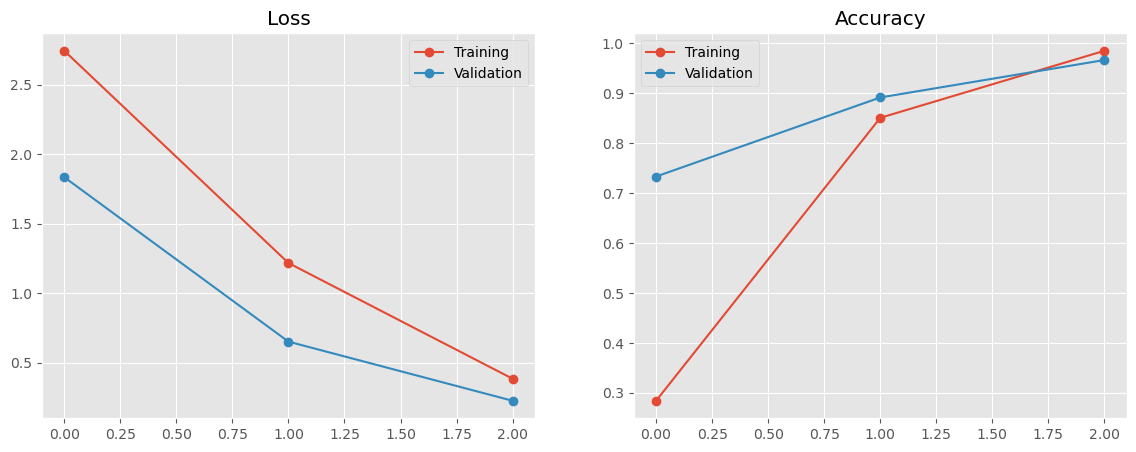

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()


## Testing the model on custom input.

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
pred1 = pipe("I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. ")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")


print(pred1[0][:2])
print(pred2[0][:2])

[{'label': 'Psoriasis', 'score': 0.8491189479827881}, {'label': 'Fungal infection', 'score': 0.035281434655189514}]
[{'label': 'Typhoid', 'score': 0.8686056733131409}, {'label': 'peptic ulcer disease', 'score': 0.024923037737607956}]
